In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old

Welcome to JupyROOT 6.12/04


In [2]:
def bin_vtm(vtm_df, autobin=True, start=None, end=None, dt=None):
    
    if autobin:
        dt = 1000
        start = np.ceil(vtm_df.index.values[0]/dt)*dt
        end = np.floor(vtm_df.index.values[-1]/dt)*dt
        
    bin_edges = np.arange(start, end+dt, dt)
    bin_centers = np.arange(start, end, dt)+dt/2
        
    bin_df = vtm_df.groupby(pd.cut(vtm_df.index, bin_edges)).mean()
    bin_df.index = bin_centers
    return bin_df

def azi_avg_vtm(bin_df):
    azi_avg_df = pd.DataFrame(np.zeros((bin_df.shape[0],6)),
                              index = bin_df.index,
                              columns = ['m' + str(m) for m in np.arange(6)+1])

    for m in range(5):
        weight = (trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1])%360
        total_weight = np.nansum(weight)
        stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
        azi_avg_df['m'+str(m+1)] = bin_df[stm_list].multiply(weight).sum(axis=1)/total_weight
        
    return azi_avg_df


In [3]:
vtm_dict = {'60hr':['vtm_1'],
            '9day':['vtm_1', 'vtm_2', 'vtm_3', 'vtm_4'],
            'endgame':['vtm_2', 'vtm_3', 'vtm_4', 'vtm_5', 'vtm_6'],
            'highkick':['vtm_1', 'vtm_2']}

In [6]:
filename = 'endgame_vtms_unblinded_2020-04-15'
bloch_filename = 'endgame_blochlike_vtms_unblinded_2020-04-15'
vtm = 'vtm_2'

in_file = 'hdf5/' + filename +'.h5'
out_file = 'utility_files/' + filename + '_' + vtm + '.csv'

bloch_in_file = 'hdf5/' + bloch_filename +'.h5'
bloch_out_file = 'utility_files/' + bloch_filename + '_' + vtm + '.csv'

vtm_binned_df = bin_vtm(pd.read_hdf(in_file, key=vtm), autobin=True)
vtm_binned_df_bloch = bin_vtm(pd.read_hdf(bloch_in_file, key=vtm), autobin=True)

avg_df = azi_avg_vtm(vtm_binned_df)
avg_df_bloch = azi_avg_vtm(vtm_binned_df_bloch)

avg_df.to_csv(out_file)
avg_df_bloch.to_csv(bloch_out_file)

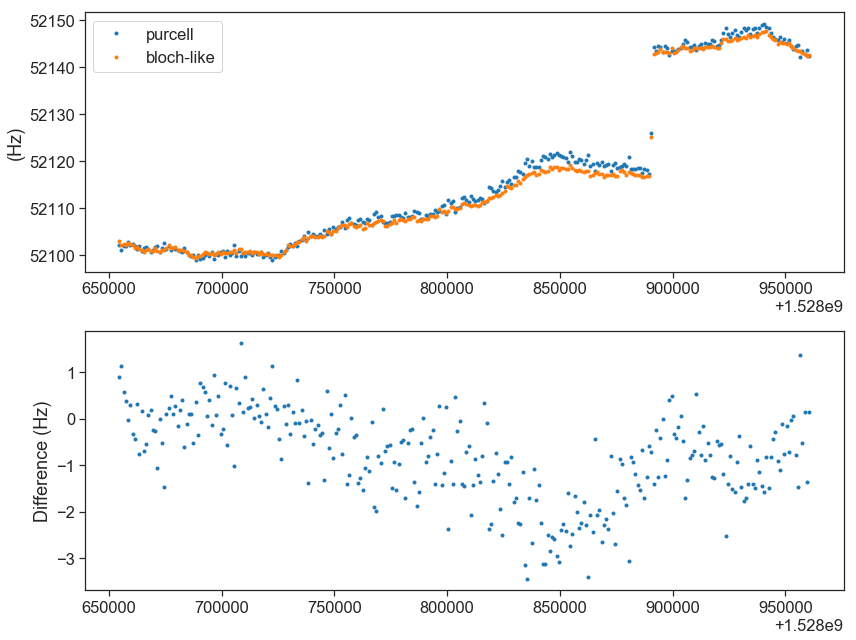

In [7]:
m = 'm1'

fig, axs = plt.subplots(2,1)

axs[0].plot(avg_df.index.values, avg_df[m], '.', label='purcell')
axs[0].plot(avg_df_bloch.index.values, avg_df_bloch[m], '.', label='bloch-like')
axs[0].set_ylabel('(Hz)')
axs[0].legend()

axs[1].plot(avg_df.index.values, avg_df_bloch[m]-avg_df[m], '.')
axs[1].set_ylabel('Difference (Hz)')

# axs[1].plot(avg_df.index.values, avg_df_bloch[m]-avg_df[m] + 2.68* vtm_binned_df['st5,m5'].values/72 , '.')
# axs[1].set_ylabel('Difference (Hz)')

# axs[2].plot(vtm_binned_df.index.values, vtm_binned_df['st5,m5'].values, '.')

fig.set_size_inches(12,9)
fig.tight_layout()

In [ ]:
# old_bloch = np.loadtxt('utility_files/9day_blochlike_vtms_2020-04-01_vtm_2.csv', skiprows=1, delimiter=',')
# old_purcell = np.loadtxt('utility_files/9day_blochlike_vtms_2020-03-03_vtm_2.csv', skiprows=1, delimiter=',')

# fig, axs = plt.subplots(2,1)

# axs[0].plot(old_purcell[:,0], old_purcell[:,1], '.', label='old')
# axs[0].plot(old_bloch[:,0], old_bloch[:,1], '.', label='new')
# axs[0].set_ylabel('(Hz)')
# axs[0].legend()

# axs[1].plot(old_purcell[:,0], old_bloch[:,1]-old_purcell[:,1], '.')
# axs[1].set_ylabel('Difference (Hz)')

# # axs[1].plot(avg_df.index.values, avg_df_bloch[m]-avg_df[m] + 2.68* vtm_binned_df['st5,m5'].values/72 , '.')
# # axs[1].set_ylabel('Difference (Hz)')

# # axs[2].plot(vtm_binned_df.index.values, vtm_binned_df['st5,m5'].values, '.')

# fig.set_size_inches(12,9)
# fig.tight_layout()

In [ ]:
# avg_df.to_csv('utility_files/9day_2020-03-03.csv')
# avg_df_bloch.to_csv('utility_files/9day_blochlike_2020-03-03.h5')

In [ ]:
fig, axs = plt.subplots(2,1)

axs[0].plot(avg_df.index.values, avg_df['m1'], '.')
axs[0].plot(avg_df_bloch.index.values, avg_df_bloch['m1'], '.')

axs[1].plot(avg_df.index.values, avg_df_bloch['m1']-avg_df['m1'], '.')

fig.set_size_inches(12,8)
fig.tight_layout()

In [ ]:
old_df = pd.read_csv('utility_files/9day_blochlike_vtms_2020-03-03_vtm_2.csv', index_col=0)

fig, axs = plt.subplots(2,1)

axs[0].plot(old_df.index.values, old_df['m1'], '.')
axs[0].plot(avg_df_bloch.index.values, avg_df_bloch['m1'], '.')

axs[1].plot(avg_df.index.values, avg_df_bloch['m1']-old_df['m1'], '.')

fig.set_size_inches(12,8)
fig.tight_layout()

In [ ]:
for dataset in vtm_dict:
    print 'Dataset: ' + dataset
    input_filename = 'hdf5/'+dataset+'_moments_blinded_sanitized.h5'
    for key in vtm_dict[dataset]:
        print '\tKey: '+ key
        azi_avg_df = azi_avg_vtm(bin_vtm(pd.read_hdf(input_filename, key=key)))
        output_filename = 'hdf5/comparison/'+dataset+'_'+key+'_comparison.csv'
        azi_avg_df.to_csv(output_filename, float_format='%.2f')

In [ ]:
vtm_df=pd.read_hdf('hdf5/9day_vtms_2020-03-03.h5', key='vtm_2')

In [ ]:
azi_avg_df = azi_avg_vtm(vtm_df)

In [ ]:
import allantools

In [ ]:
taus_in = np.round(np.power(10, np.arange(0,5,0.05)))

fig, axs = plt.subplots(1,1)

taus, adev, _, _ = allantools.oadev(azi_avg_df['m1'].values, data_type='freq', rate=1, taus=taus_in)
axs.loglog(taus, adev, '.')

axs.set_xlabel('Averaging time (sec)')
axs.set_ylabel('Allan deviation (Hz)')
axs.set_title('Sample Allan deviation (9day pair 2)')
fig.set_size_inches(8,6)
fig.tight_layout()